In [ ]:
import pandas as pd
import gc
import numpy as np
import datetime
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

from sklearn.preprocessing import LabelEncoder

import platform
# 차트에서 한글 출력을 위한 설정
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()

    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)


import torch
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더

device = torch.device('cuda')


gc.collect()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


0

In [ ]:
df_tr = pd.read_csv('train_02.csv', encoding = "utf-8")
test = pd.read_csv('test_02.csv', encoding = "utf-8")
test = test.loc[test['PM2.5'].isna() == False].reset_index().iloc[:,1:]

sub = pd.read_csv('answer_sample.csv')

In [ ]:
df_tr.shape, test.shape

((596088, 20), (52224, 20))

## Feature Extraction

In [ ]:
df_tr.head()

,연도,일시,측정소,기온(°C),풍향(deg),풍속(m/s),강수량(mm),습도(%),hour,day,month,week,day_hour_mean,hour_mean,hour_std,sin_time,cos_time,THI,CDH,PM2.5
0,0,01-01 00:00,0,0.173776,0.201944,0.023018,0.0,0.828,0,1,1,1,0.094667,0.092682,0.072309,0.000000,1.000000,45.681459,-25.826224,0.056
1,0,01-01 01:00,0,0.176935,0.168611,0.030691,0.0,0.831,1,1,1,1,0.097167,0.093720,0.073359,0.258819,0.965926,45.683797,-51.649289,0.060
2,0,01-01 02:00,0,0.180095,0.087222,0.033248,0.0,0.784,2,1,1,1,0.098750,0.093761,0.074204,0.500000,0.866025,45.741984,-77.469194,0.068
3,0,01-01 03:00,0,0.178515,0.087222,0.025575,0.0,0.745,3,1,1,1,0.097500,0.093785,0.073851,0.707107,0.707107,45.782737,-103.290679,0.060
4,0,01-01 04:00,0,0.164297,0.113889,0.020460,0.0,0.750,4,1,1,1,0.097417,0.093501,0.073633,0.866025,0.500000,45.751553,-129.126382,0.068


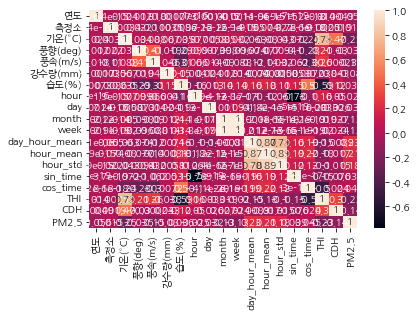

In [ ]:
sns.heatmap(df_tr.corr(), annot = True)
plt.show()

In [ ]:
# 측정소 encoding
enc = LabelEncoder()

df_tr['측정소'] = enc.fit_transform(df_tr['측정소'])
test['측정소'] = enc.transform(test['측정소'])

## DataLoader

* Split train/val

In [ ]:
train = pd.DataFrame(columns = df_tr.columns)
val = pd.DataFrame(columns = df_tr.columns)

for r in tqdm(df_tr.측정소.unique().tolist()):
    a = df_tr.loc[df_tr.측정소 == r].reset_index().iloc[:,1:]
    for i in range(df_tr.연도.nunique()):
        b = a.loc[a.연도 == i]
        train_size = int(b.shape[0]*0.8)
        train_set = b.iloc[0:train_size,:].reset_index().iloc[:,1:]
        val_set = b.iloc[train_size:, :].reset_index().iloc[:,1:]

        train = pd.concat([train, train_set], axis = 0)
        val = pd.concat([val, val_set], axis = 0)

In [ ]:
train = train.drop(columns = '일시')
val = val.drop(columns = '일시')
test = test.drop(columns = '일시')

train = train.astype(float)
val = val.astype(float)
test = test.astype(float)

train.shape, val.shape, test.shape

* Sliding Window

In [ ]:
seq_length = 2
output_dim = 3
batch_size = 64

In [ ]:
def build_train_dataset(time_series, seq_length, output_dim):
    dataX = []
    dataY = []

    for r in tqdm(time_series.측정소.unique().tolist()):
        a = time_series.loc[time_series.측정소 == r].values
        for i in range(0, (a.shape[0]//((seq_length+output_dim)*24))*((seq_length+output_dim)*24), (seq_length+output_dim)*24):
            _x = a[i:i+seq_length*24, :]
            _y = a[i+seq_length*24:(i+seq_length*24)+output_dim*24, [-1]].reshape(-1)

            dataX.append(_x)
            dataY.append(_y)

    return np.array(dataX), np.array(dataY)


def build_test_dataset(time_series):
    dataX = []
    for r in tqdm(time_series.측정소.unique().tolist()):
        a = time_series.loc[time_series.측정소 == r].values
        for i in range(0,a.shape[0]//48):
            _x = a[i*48:(i*48)+48,:]
            dataX.append(_x)

    return np.array(dataX)

In [ ]:
trainX, trainY = build_train_dataset(train, seq_length, output_dim)
valX, valY = build_train_dataset(val, seq_length, output_dim)
testX = build_test_dataset(test)

In [ ]:
trainX.shape, trainY.shape, valX.shape, valY.shape, testX.shape

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [ ]:
## Train
train_dataset = TensorDataset(torch.tensor(trainX, dtype=torch.float32).to(device),
                              torch.tensor(trainY, dtype=torch.float32).to(device))

val_dataset = TensorDataset(torch.tensor(valX, dtype=torch.float32).to(device),
                              torch.tensor(valY, dtype=torch.float32).to(device))

## Test
testX_tensor = torch.FloatTensor(testX)

In [ ]:
train_dataloader = DataLoader(train_dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        drop_last=True)

val_dataloader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        drop_last=True)

## Model

In [ ]:
# 설정값
data_dim = trainX.shape[2] # input feature
hidden_dim = 32
learning_rate = 0.01
nb_epochs = 200

In [ ]:
class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        #self.seq_len = seq_len
        self.output_dim = output_dim
        self.layers = layers

        self.lstm1 = torch.nn.LSTM(input_dim, hidden_dim, num_layers=layers,
                            #dropout = 0.8,
                            batch_first=True)
        self.lstm2 = torch.nn.LSTM(hidden_dim, 384, num_layers=layers,
                            #dropout = 0.8,
                            batch_first=True)
        self.fc = torch.nn.Linear(384, 72, bias = True)
        #self.ReLU = torch.nn.ReLU()
        #self.fc2 = torch.nn.Linear(16, output_dim, bias = True)

    # 학습 초기화를 위한 함수
    def reset_hidden_state(self):
        self.hidden = (
                torch.zeros(self.layers, 48, self.hidden_dim),
                torch.zeros(self.layers, 48, self.hidden_dim))

    # 예측을 위한 함수
    def forward(self, x):
        x, _status = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = self.fc(x[:, -1])
        #x = self.ReLU(x)
        #x = self.fc2(x)
        return x

In [ ]:
# 모델 학습
net = Net(data_dim, hidden_dim, output_dim, 1).to(device)
net

In [ ]:
def train_model(model, train_df, num_epochs = None, lr = None, verbose = 10, patience = 10):

    criterion = torch.nn.L1Loss().to(device) # MAE loss로 학습해보기
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) # weight_decay : 규제항  / SGD / AdamW
    nb_epochs = num_epochs

    # epoch마다 loss 저장
    train_hist = np.zeros(nb_epochs)
    for epoch in range(nb_epochs):
        avg_cost = 0
        total_batch = len(train_df)

        for batch_idx, samples in enumerate(train_df):

            x_train, y_train = samples
            batch_size = x_train.size(0)
            x_train = x_train.to(device)
            y_train = y_train.to(device)
            # seq별 hidden state reset
            model.reset_hidden_state()

            # H(x) 계산
            outputs = model(x_train)

            # cost 계산
            loss = criterion(outputs, y_train)

            # cost로 H(x) 개선
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            avg_cost += loss/total_batch

        train_hist[epoch] = avg_cost

        if epoch % verbose == 0:
            print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))

    return model.eval(), train_hist

In [ ]:
model, train_hist = train_model(net, train_dataloader, num_epochs = nb_epochs, lr = learning_rate, verbose = 20, patience = 10)

In [ ]:
# epoch별 손실값
fig = plt.figure(figsize=(10, 4))
plt.plot(train_hist, label="Training loss")
plt.title('loss')
plt.legend()
plt.show()

In [ ]:
# 모델 저장
now = datetime.datetime.now().strftime('model_%m-%d_%H:%M')


PATH = './' + now + '.pth'
torch.save(model.state_dict(), PATH)

### Validation

In [ ]:
def evaluate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0
    lst = []
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            y_pred = model(x_val)
            loss = criterion(y_pred, y_val)
            val_loss += loss.item() * x_val.size(0)
            lst.append(y_pred)
    val_loss /= len(val_loader.dataset)


    model.train()

    print('Validation MAE: {:.4f}'.format(val_loss))
    return lst
# 모델의 성능 평가
criterion = torch.nn.L1Loss().to(device)
a = evaluate_model(net, val_dataloader, criterion)

### Prediction

In [ ]:
# Load pre-trained model
net = Net(data_dim, hidden_dim, output_dim, 1).to(device)
net.load_state_dict(torch.load(PATH), strict=False)
net.eval()

In [ ]:
# Prediction
with torch.no_grad():
    pred = []
    for pr in range(len(testX_tensor)):
        testX_tensor = testX_tensor.to(device)
        model.reset_hidden_state()

        predicted = model(torch.unsqueeze(testX_tensor[pr], 0))
        pred.append(predicted)

In [ ]:
a = [np.array(pred[i].cpu()).reshape(72) for i in range(len(pred))]
b = [a[i].tolist() for i in range(len(a))]

### Submission

In [ ]:
sub['PM2.5'] = sum(b, [])

In [ ]:
sub.to_csv('baseline_{}.csv'.format(now[6:]), index = False)

In [ ]:
pd.read_csv('baseline_{}.csv'.format(now[6:])).isna().sum()